<div class="alert alert-block alert-info">
    <img style="float: right;" src="https://raw.githubusercontent.com/OpenSourceEconomics/ose-corporate-design/master/logos/OSE_logo_RGB.svg" width="150">
    <u><h1>Respy Tutorial Lecture</h1></u>
</div>

### What is respy?

respy is an open source framework written in Python for the simulation and estimation of some finite-horizon discrete choice dynamic programming models. The group of models which can be currently represented in respy are called Eckstein-Keane-Wolpin models (Aguirregabiria and Mira (2010)).

### Why should I use the package?

What makes respy powerful is that it allows to build and solve structural models in weeks or months whose development previously took years. The design of respy allows the researcher to flexibly add the following components to her model.

### What should I expect from this presentation?

The upcoming tutorial provides an example on how you can utilize respy to set up your own model. For this purpose we showcase the implementation of a Robinson Crusoe economy as a discrete choice dynamic programming model.

### Why do you use a toy model if your package is 

Just to be clear, don't misinterpret the fact that we explain respy using such a simplistic model. respy is not a toy and can just as well solve state-of-the-art structural models. It's just easier to explain respy and its features in a situation where we don't have to explain a complicated model at the same time.



<div class="alert alert-block alert-info">
    <u><h2>Preliminaries</h2></u>
</div>

In [1]:
import yaml
import numpy as np
import pandas as pd
import respy as rp
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from auxiliary.auxiliary import plot_choice_prob, plot_choice_prob_and_exp_level, plot_choice_shares

plt.style.use("plot_config/respy.mplstyle")

<div class="alert alert-block alert-info">
    <u><h2>A simple model: Robinson Crusoe</h2></u>
</div>

## Model outline
> After setting sail against his parents' wishes, being captured by pirates, escaping from them, building a plantation, and setting sail again to capture slaves in Africa, [Robinson Crusoe](https://en.wikipedia.org/wiki/Robinson_Crusoe) stranded on a small island. He is alone with one dog, two cats, and only some supplies. He goes fishing to make ends meet and if he is too tired he will relax in his hammock. But, he cannot relax to often as storing food is a difficult task on a tropical island.


- Robinson chooses every period $t = 0, \dots, T - 1$ to either go fishing, $a = 0$, or spend the day in the hammock, $a = 1$.

- The utility of a choice, $U(s_t, a_t)$, depends on the state $s_t$, which contains information on the individual's characteristics, and the chosen alternative $a_t$.

- For working alternatives like fishing utility consists of two components, a wage and a non-pecuniary component:

$$
    U(s_t, a_t) = \underbrace{W(s_t, a_t)}_{wage} + \underbrace{N(s_t, a_t)}_{non-pecuniary}
$$

- For non-working alternatives like the hammock, $W(s_t, 1) = 0$. Otherwise the wage is defined as
$$\begin{align}
    \\
    \\
        W(s_t, 0) &= r_a \exp\{x^w_{at} \beta^w_a + \epsilon_{at}\}\\
        \\
    \ln(W(s_t, 0)) &= \ln(r_a) + x^w_{at} \beta^w_a + \epsilon_{at}\\
    \\
\end{align}$$

    * $r_a$ is normally a market rental price for the skill units generated in the exponential expression. Another interpretation is that $ln(r_a)$ is simply the constant in the skill units.    
    * $x^w_{at}$ and $\beta^w_a$ are the choice- and time-dependent covariates and parameters related to the wage signaled by superscript $w$. 
    * $\epsilon_{at}$ is a choice-specific random shock from the shock vector $\epsilon_t \sim \mathcal{N}(0, \Sigma)$ for all choices. Shocks are usually correlated across choices in one period, but are independent across periods.


- The non-pecuniary rewards for working alternatives are a vector dot product of covariates $x_t^w$ and parameters $\beta^w$. The superscript $w$ signals that the components belong to working alternatives.

$$
    N^w(s_t, a_t) = x_t^w\beta^w
$$

- If Robinson chooses to go fishing, he gains one additional unit of experience in the next period. Experience starts at zero and goes over 1, 2, 3 up to $T - 1$.


- General assumption: Robinson is forward-looking and maximizes the expected present value of utility over the remaining lifetime. W.l.o.g. $t = 0$ and let $V(s_0)$ define the value of the maximization which is achieved by a sequence of choices, $\{a_t\}^T_{t = 0}$, such that every action is in the choice set, $a_t \in C(s_t)$ and $s_{t + 1}$ adheres to the law of motion. Then, the expected present value of lifetime utility in state $s_0$ is

$$
    V(s_0) = \text{E} \max_{\{a_t\}^T_{t = 0}} \left[
        \sum^T_{t = 0} \delta^t U(s_t, a_t) \, \Big|
        \, a_t \in C(s_t), s_{t+1} = m(s_t, a_t)
    \right]
$$

- Note that the shocks in period $t = 0$ are not stochastic. Thus, one can extract the utility in the current period $U(s_0, a_0)$, also called the flow utility, and the discount factor $\delta$ from the expectation. Then, the formula can be rewritten so that the second term becomes the maximum over alternative-specific value functions at time $t = 1$ which are also called continuation values.

$$\begin{align}
    V(s_0) &= \max_{a_0} \, U(s_0, a_0) + \delta \text{E} \max_{\{a_t\}^T_{t = 1}}
              \left[
                  \sum^T_{t = 1} \delta^{t - 1} U(s_t, a_t) \, \Big|
                  \, a_t \in C(s_t), s_{t + 1} = m(s_t, a_t)
              \right] \\
           &= \max_{a_0} \, \underbrace{U(s_0, a_0)}_{\text{float utility}}
              + \delta \underbrace{\text{E} \max_{a_1} V_{a_1}(s_1)}_{\text{continuation value}}
\end{align}$$

-The maximum over alternative-specific value functions can be rewritten as the value function of state $s_1$ or $V(s_1) = \max_{a_1} V_{a_1}(s_1)$ which yields the famous Bellman equation. Due to the recursive nature of the problem, the alternative-specific value functions are defined as

$$\begin{equation}
    V_a(s_t) = \begin{cases}
        U(s_t, a_t) + \delta \text{E} V(s_{t+1}) & \text{if } t < T \\
        U(s_t, a_t) & \text{if } t = T
    \end{cases}
\end{equation}$$

-The former equation shows that the shocks in period $t + 1$ are unknown to the individual in period $t$. Thus, utility must be maximized given the joint distribution of shocks in period $t + 1$ which is a maximization problem over a two-dimensional integral. Denote the non-stochastic part of a state as $s^-$. Then, Robinson maximizes

$$\begin{equation}
    V(s_t) = \max_{a_t}\{
        U(s_t, a_t) + \delta \int_{\epsilon_{0, t + 1}} \dots \int_{\epsilon_{2, t + 1}}
        \max_{a_{t + 1}} V_{a_{t + 1}}(s^-_{t + 1}, \epsilon_{t + 1})
        f_\epsilon(\epsilon_{t + 1})
        d_{\epsilon_{0, t + 1}} \dots d_{\epsilon_{2, t + 1}}
    \}
\end{equation}$$

## Specifying the model

Next we have to provide respy with the specifications of our model. For this purpose we create two objects that we will feed to the package.


In [2]:
params_basic = pd.read_csv("params_files/robinson_crusoe_basic.csv", index_col=["category", "name"])
params_basic

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.15
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                0.50
                        sd_hammock                0.50
                        corr_hammock_fishing      0.00
lagged_choice_1_hammock constant                  1.00

The `params` object is complemented with `options` which contains additional information. 


In [3]:
options_basic = yaml.safe_load(open("option_files/options_basic.yml"))
options_basic

{'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 1323,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"}}

## Simulating the model

We are now ready to simulate the model.

In [4]:
simulate = rp.get_simulate_func(params_basic, options_basic)
df_basic = simulate(params_basic)

In [5]:
df_basic.head(10)

Experience_Fishing Lagged_Choice_1  Shock_Reward_Fishing  \
Identifier Period                                                             
0          0                        0         hammock              0.820712   
           1                        1         fishing              0.797960   
           2                        1         hammock              0.006137   
           3                        2         fishing              0.342000   
           4                        2         hammock             -0.817412   
           5                        3         fishing              0.088770   
           6                        4         fishing              0.038157   
           7                        4         hammock             -1.705825   
           8                        4         hammock             -0.083566   
           9                        5         fishing              0.359250   

                   Meas_Error_Wage_Fishing  Shock_Reward_Hammock  \
Identifier Period                                                  
0          0                             1             -1.710178   
           1                             1              0.585223   
           2                             1             -1.065115   
           3                             1             -0.060883   
           4                             1             -0.812382   
           5                             1             -2.073206   
           6                             1             -0.914505   
           7                             1              0.982573   
           8                             1             -0.057721   
           9                             1              0.259021   

                   Meas_Error_Wage_Hammock  Dense_Key  Core_Index   Choice  \
Identifier Period                                                            
0          0                             1          0           1  fishing   
           1                             1          1           0  hammock   
           2                             1          2           0  fishing   
           3                             1          3           4  hammock   
           4                             1          4           2  fishing   
           5                             1          5           7  fishing   
           6                             1          6          11  hammock   
           7                             1          7          12  hammock   
           8                             1          8           0  fishing   
           9                             1          9          12  hammock   

                       Wage  ...  Nonpecuniary_Reward_Fishing  Wage_Fishing  \
Identifier Period            ...                                              
0          0       1.507354  ...                           -1      1.507354   
           1            NaN  ...                           -1      1.731486   
           2       1.165405  ...                           -1      1.165405   
           3            NaN  ...                           -1      1.601595   
           4       0.896994  ...                           -1      0.896994   
           5       1.639490  ...                           -1      1.639490   
           6            NaN  ...                           -1      1.857215   
           7            NaN  ...                           -1      0.776536   
           8       1.747554  ...                           -1      1.747554   
           9            NaN  ...                           -1      2.533559   

                   Flow_Utility_Fishing  Value_Function_Fishing  \
Identifier Period                                                 
0          0                   0.507354               13.787587   
           1                   0.731486               13.613580   
           2                   0.165405               11.560440   
           3                   0

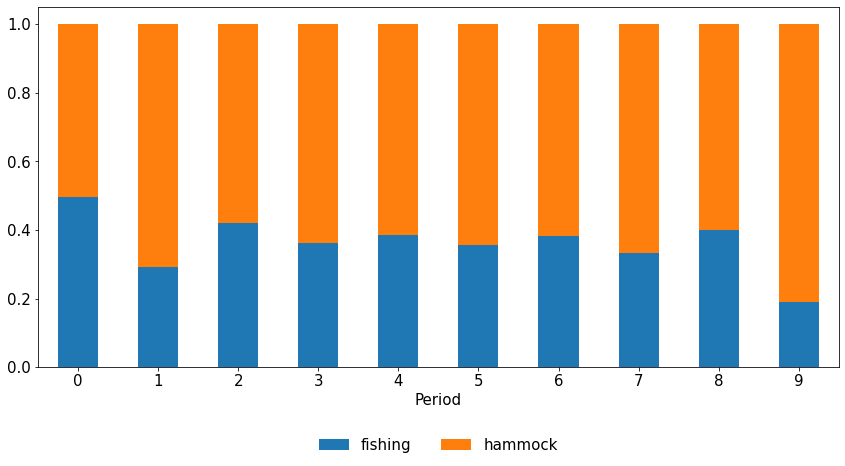

In [6]:
plot_choice_shares(df_basic)

<AxesSubplot:xlabel='Choice', ylabel='Lagged_Choice_1'>

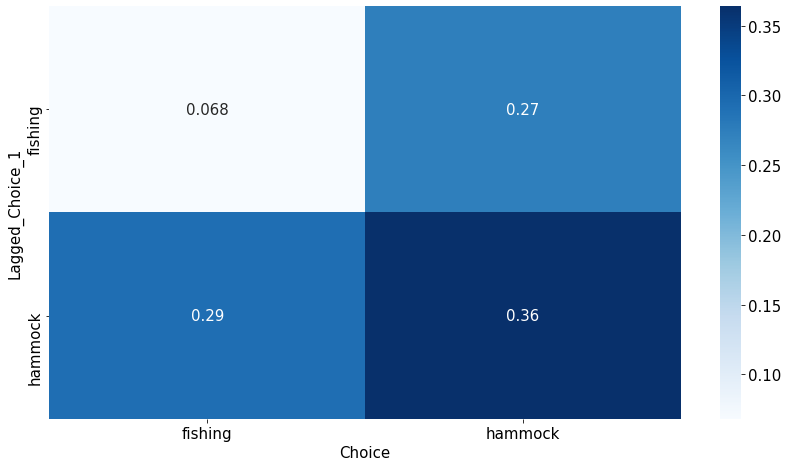

In [7]:
data = pd.crosstab(df_basic.Lagged_Choice_1, df_basic.Choice, normalize=True)
sns.heatmap(data, cmap="Blues", annot=True)

<div class="alert alert-block alert-info">
    <u><h2>Extending Robinson Crusoe</h2></u>
</div>

As already stated in the introduction, one of the main advantages of respy is that the package is flexible regarding the model structure. We will illustrate this by extending the previously introduced model framework in several different ways.

## Covariates

Next we want to add another covariate. As before we concentrate on a simple example, but this can be extended in any direction. The simplest covariate is the constant. We also had before the covariate not fishing last period. We saw in the examples above.

A covariate in respy allows to specify advanced return structures to each choice. First, we need to define the covariate in the option file. In a second step, we specify the return for the choice for this covariate.

In [54]:
params_age = pd.read_csv("params_files/robinson_crusoe_age.csv", index_col=["category", "name"])
params_age

value
category                name                          
delta                   delta                    0.950
wage_fishing            exp_fishing              0.150
                        age                     -0.015
nonpec_fishing          constant                -1.000
nonpec_hammock          constant                 2.500
                        not_fishing_last_period -1.000
shocks_sdcorr           sd_fishing               0.500
                        sd_hammock               0.500
                        corr_hammock_fishing     0.000
lagged_choice_1_hammock constant                 1.000

In [26]:
options_age = yaml.safe_load(open("option_files/options_age.yml"))
options_age

{'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'",
  'age': 'period + 16'}}

In [52]:
simulate = rp.get_simulate_func(params_age, options_age)
df_age = simulate(params_age)

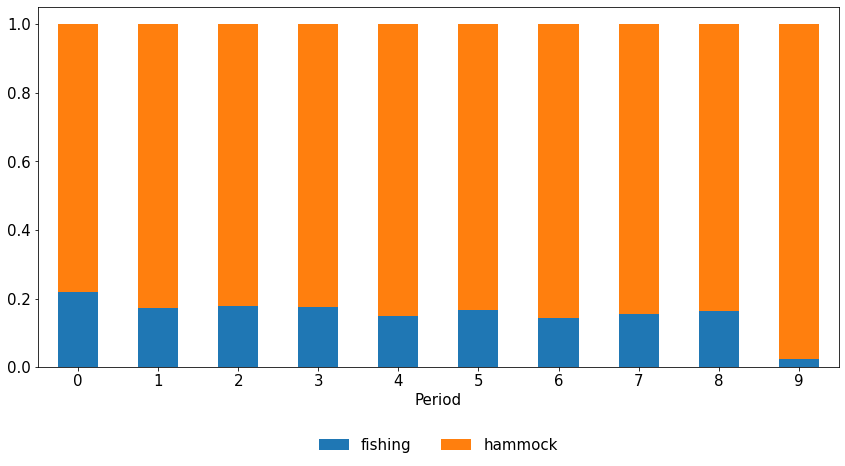

In [53]:
plot_choice_shares(df_age)

## Altering the choice set

> At some point Crusoe notices that a group of cannibals occasionally visits the island and celebrate one of their dark rituals. But then, a prisoner can escape and becomes Crusoe's new friend Friday whom he teaches English. In return Friday can share his knowledge once to help Robinson improve his fishing skills, but that is only possible after Robinson tried at least once to go fishing.

A common extension to structural models is to increase the choice set. Here, we want to add another choice called `"friday"` which affects the utility of fishing. The choice should be available once, starting with the third period, and only after Robinson has been fishing before.




In [59]:
params_friday = pd.read_csv("params_files/robinson_crusoe_friday.csv", index_col=["category", "name"])
params_friday

value
category                name                            
delta                   delta                       0.95
wage_fishing            exp_fishing                 0.10
                        contemplation_with_friday   0.40
nonpec_fishing          constant                   -1.00
nonpec_friday           constant                   -1.00
                        not_fishing_last_period    -1.00
nonpec_hammock          constant                    2.50
                        not_fishing_last_period    -1.00
shocks_sdcorr           sd_fishing                  1.00
                        sd_friday                   1.00
                        sd_hammock                  1.00
                        corr_friday_fishing         0.00
                        corr_hammock_fishing        0.00
                        corr_hammock_friday         0.00
lagged_choice_1_hammock constant                    1.00

Turning to the `options`, we can see that the new covariate `"contemplation_with_friday"` is only affecting utility if Robinson is experienced in fishing and only for one interaction with friday. This naturally limits the interaction with Friday. The key `"negative_choice_set"` can be used to restrict the choice Friday to the third and following periods. The first key matches a choice. The value of the key can be a list of strings. If the string evaluates to `True`, a utility penalty ensures that individuals will never choose the corresponding states. 

In [60]:
options_friday = yaml.safe_load(open("option_files/options_friday.yml"))
options_friday

{'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 500,
 'solution_seed': 456,
 'covariates': {'constant': '1',
  'contemplation_with_friday': 'exp_friday == 1 and exp_fishing >= 1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"},
 'negative_choice_set': {'friday': ['period < 2', 'exp_fishing == 0']},
 'core_state_space_filters': ["period > 0 and exp_fishing + exp_friday == period and lagged_choice_1 == 'hammock'",
  'period <= 2 and exp_friday != 0',
  'period >= 3 and period - exp_friday < 2',
  'exp_friday > 0 and exp_fishing == 0',
  "exp_friday > 0 and exp_fishing == 1 and lagged_choice_1 == 'fishing'",
  "period - exp_friday == 2 and lagged_choice_1 != 'friday' and period > 2",
  "exp_{choices_w_exp} == 0 and lagged_choice_1 == '{choices_w_exp}'"]}

In [61]:
simulate = rp.get_simulate_func(params_friday, options_friday)
df_friday = simulate(params_friday)

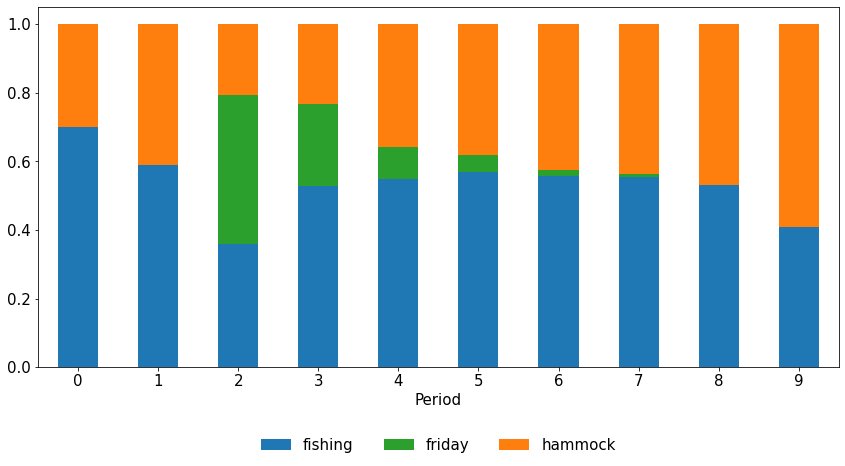

In [62]:
plot_choice_shares(df_friday, friday=True)

<AxesSubplot:xlabel='Choice', ylabel='Lagged_Choice_1'>

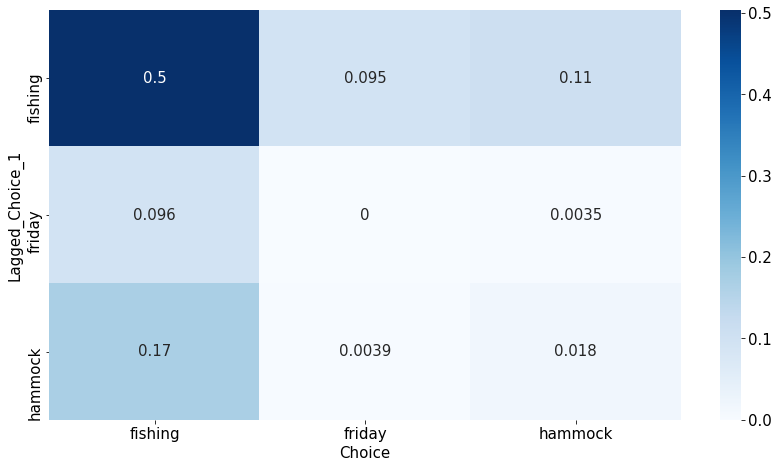

In [16]:
data = pd.crosstab(df_friday.Lagged_Choice_1, df_friday.Choice, normalize=True)
sns.heatmap(data, cmap="Blues", annot=True)

## Initial experience

Next we will introduce how we can include heterogeneity in intitial conditions in `respy`: in period $t=0$, Robinson will be allowed to have $0$, $1$, or $2$ periods of experience in fishing.

In [17]:
params_basic = pd.read_csv("params_files/robinson_crusoe_basic.csv", index_col=["category", "name"])
params_basic

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.15
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                0.50
                        sd_hammock                0.50
                        corr_hammock_fishing      0.00
lagged_choice_1_hammock constant                  1.00

To allow Robinson to have nonzero experience in fishing in the first period, we need to modify `params`: We specify the distribution of initial experience via **probability mass functions**, as the probabilities do not depend on any information. 
The keyword is `"initial_exp_fishing_*"` in the category-level of the index, where the asterisk needs to be replaced with the experience level. In the name-level, use `"probability"` to signal that the float in `"value"` is a probability. 

The new parameter specification is below: Robinson has equal probability to start out with 0, 1 or 2 periods of experience. However, one probability is set to 0.34 so that all probabilities sum to one. If that is not the case, `respy` will emit a warning and normalize probabilities.

In [18]:
params_initial_exp = params_basic.copy()
params_initial_exp.loc[("initial_exp_fishing_0", "probability"), "value"] = 0.33
params_initial_exp.loc[("initial_exp_fishing_1", "probability"), "value"] = 0.33
params_initial_exp.loc[("initial_exp_fishing_2", "probability"), "value"] = 0.34
params_initial_exp

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.15
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                0.50
                        sd_hammock                0.50
                        corr_hammock_fishing      0.00
lagged_choice_1_hammock constant                  1.00
initial_exp_fishing_0   probability               0.33
initial_exp_fishing_1   probability               0.33
initial_exp_fishing_2   probability               0.34

In [19]:
simulate = rp.get_simulate_func(params_initial_exp, options_basic)
df_exp = simulate(params_initial_exp)

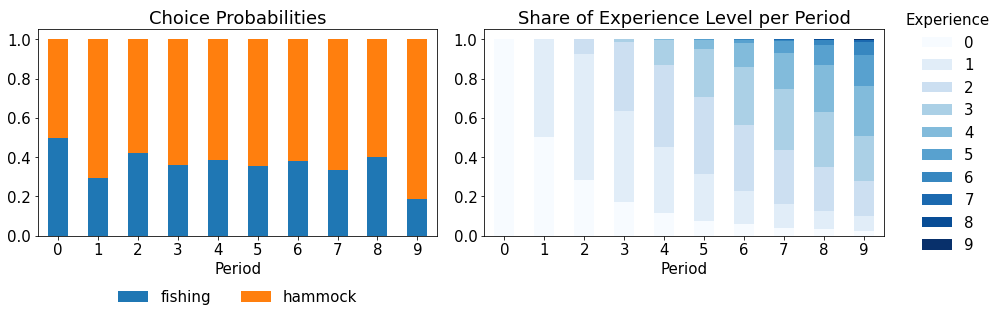

In [20]:
plot_choice_prob_and_exp_level(df_basic)

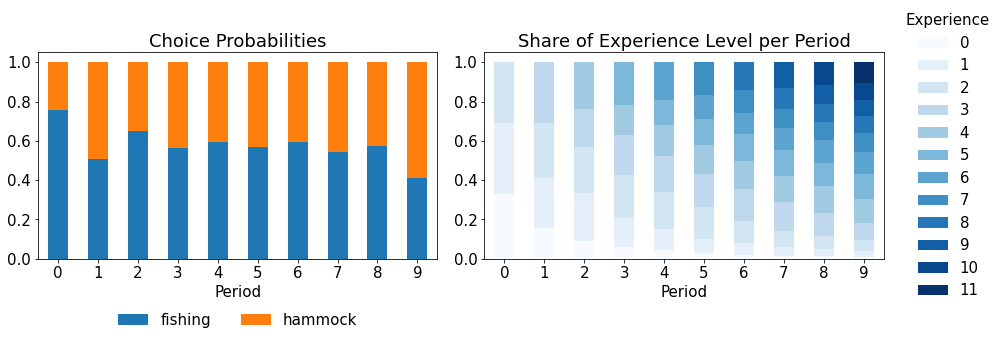

In [21]:
plot_choice_prob_and_exp_level(df_exp)

## Observables

Next add one observable characteristic to the baseline model, `"Fishing_Grounds"`: Now Robinson can end up, with a certain probability, on the side of the island which has `"poor"` or `"rich"` fishing grounds. Experiencing rich fishing grounds affects the **non-pecuniary reward** for fishing: 

$$\begin{align}
N^f = \alpha^f + \zeta^f \unicode{x1D7D9}_{\{FG = "rich"\}} \\
\end{align}$$

The indicator function $\unicode{x1D7D9}_{\{condition\}}$ takes value 1 when the condition is true and value 0 otherwise: Therefore, if Robinson finds himself in rich fishing grounds, his total non-pecuniary rewards from fishing will be equal to $\alpha^f + \zeta^f$.

to specify the observable, we add three additional rows to params:

- The probability with which Robinson will find himself in rich and in poor fishing grounds;

- The value of ζf, which here is set to be positive and constant.

respy allows for complex probability distributions of observables, which may for instance depend on other covariates. However, throughout this tutorial, we will assume that the observables’ probability distributions do not depend on any other information, and we will add them to the model via probability mass function: Each Robinson is randomly assigned to a certain side of the island, according to the float specified under value in the name-level probability.

Note that all probabilities sum to one. If that is not the case, respy will emit a warning and normalize probabilities.

In [22]:
params_fish_ground = params_basic.copy()
params_fish_ground.loc[("observable_fishing_grounds_rich", "probability"), "value"] = 0.5
params_fish_ground.loc[("observable_fishing_grounds_poor", "probability"), "value"] = 0.5
params_fish_ground.loc[("nonpec_fishing", "rich_fishing_grounds"), "value"] = 0.5
params_fish_ground

value
category                        name                          
delta                           delta                     0.95
wage_fishing                    exp_fishing               0.15
nonpec_fishing                  constant                 -1.00
nonpec_hammock                  constant                  2.50
                                not_fishing_last_period  -1.00
shocks_sdcorr                   sd_fishing                0.50
                                sd_hammock                0.50
                                corr_hammock_fishing      0.00
lagged_choice_1_hammock         constant                  1.00
observable_fishing_grounds_rich probability               0.50
observable_fishing_grounds_poor probability               0.50
nonpec_fishing                  rich_fishing_grounds      0.50

We also need to overwrite the covariates section of options to include which level of the observable is associated with a higher nonpecuniary reward for fishing:

In [23]:
options_fish_ground = options_basic.copy()
options_fish_ground["covariates"] = {
    "constant": "1",
    'not_fishing_last_period': "lagged_choice_1 != 'fishing'",
    "rich_fishing_grounds": "fishing_grounds == 'rich'",
}
options_fish_ground

{'n_periods': 10,
 'simulation_agents': 1000,
 'simulation_seed': 1323,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'",
  'rich_fishing_grounds': "fishing_grounds == 'rich'"}}

In [24]:
simulate = rp.get_simulate_func(params_fish_ground, options_fish_ground)
df_fish_ground = simulate(params_fish_ground)

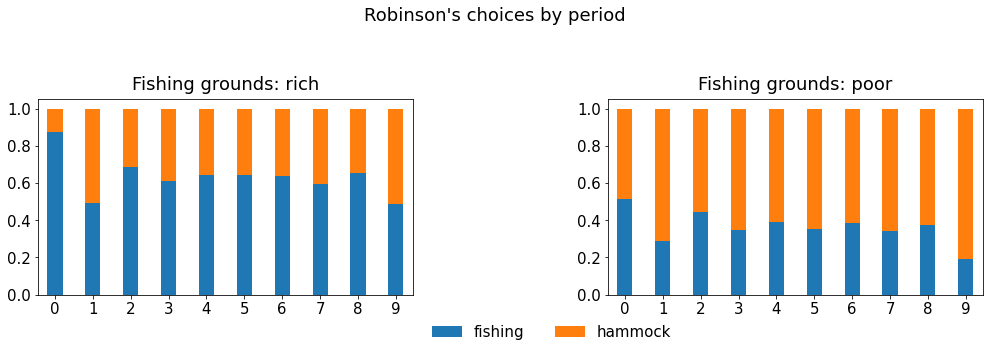

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for i, observable in enumerate(["rich", "poor"]):
    df_fish_ground.query("Fishing_Grounds == @observable").groupby("Period").Choice.value_counts(
        normalize=True,
    ).unstack().plot.bar(width=0.4, stacked=True, rot=0, legend=False, ax=ax[i])
    ax[i].set_title("Fishing grounds: " + observable, pad=10)
    ax[i].xaxis.label.set_visible(False)

plt.legend(loc="lower center", bbox_to_anchor=(-0.15, -0.3), ncol=2)
plt.suptitle("Robinson's choices by period", y=1.05)

plt.show()